<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Detector1 for MIRI TSO imaging

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br>[Run JWST Pipeline](#pipeline_ID) <br> [Examine Input and Output Data](#examine_data)  <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction

This notebook is meant to process a data set through the Detector1 pipeline for TSO imaging data (calwebb_tso1). The steps are as follow:

1) Read in an uncalibrated TSO imaging file.

2) Process through calwebb_detctor1 using parameters set in calwebb_tso1.cfg.

3) Test various steps and outputs from the pipeline run.

These steps are set up with an example simulated MIRI dataset.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst

### Defining Terms

Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

    JWST: James Webb Space Telescope
    MIRI: Mid-Infrared Instrument
    LRS: Low Resolution Spectrometer
    TSO: Time Series Observation



<a id="imports_ID"></a>
## Imports

* jwst.datamodels for building model for JWST Pipeline
* jwst.pipeline is the pipeline being tested
* matplotlib.pyplot.plt to generate plot
* numpy for array calculations and manipulation
* pysiaf to get coordinates of MIRI apertures 
* astropy.io and download_file allow downloading and accessing files
* ci_watson and get_bigdata allow accessing files stored in artifactory

In [1]:
from astropy.io import fits, ascii
from astropy.utils.data import download_file
from ci_watson.artifactory_helpers import get_bigdata
from jwst.datamodels import RampModel, ImageModel, dqflags, CubeModel
from jwst.pipeline import Detector1Pipeline
import matplotlib.pyplot as plt
import numpy as np
import os
import pysiaf

2021-04-22 16:40:03,286 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



### Read in file and update headers to have needed keywords for TSO mode


In [2]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [3]:
def checkheaders(model):
    
    # check that header has keyword TSOVISIT set to true (all TSO data should have this set)
    
    if model.meta.visit.tsovisit != True:
        model.meta.visit.tsovisit = True
        print('Setting TSOVISIT keyword')
        
    # check that CRPIX1 and CRPIX2 are set to the center of the siaf aperture for the array being used.
    # Read in array being used
    array = model.meta.subarray.name
    print(array)
    if array == 'FULL':
        siaf = pysiaf.Siaf('MIRI') 
        full = siaf['MIRIM_FULL']
        model.meta.wcsinfo.crpix1 = full.XSciRef
        model.meta.wcsinfo.crpix2 = full.YSciRef
    if array == 'SUB64':
        # subarray siaf values are not quite right in MIRISim. Need to centroid to find x and y
        # start with siaf values
        siaf = pysiaf.Siaf('MIRI')
        sub = siaf['MIRIM_SUB64']
        x_initial = sub.XSciRef - 8 # known 8 pixel shift in subarray source position fixed in latest MIRISim
        y_initial = sub.YSciRef
        
        print(x_initial, y_initial)
        
        # Take initial estimate and centroid to find source
        center = centroids.centroid_sources(model.data[0,0,:,:], x_initial, y_initial, box_size=11)
        xcentroid = center[0][0]
        ycentroid = center[1][0]
        
        print(center[0][0], center[1][0])   
        model.meta.wcsinfo.crpix1 = xcentroid
        model.meta.wcsinfo.crpix2 = ycentroid

<a id="pipeline_ID"></a>
## Run JWST Pipeline

### Set up parameters for individual steps and run calwebb_detector1

In [4]:
# set up pipeline parameters and file names
# Input file names

# This section to download data from remote box directory and run local
mainurl ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_ima_tso/"
filename = 'pipetest_miri_imtso_FULL_10g10i_F770W.fits'
file = download_file(mainurl+filename)

# open file into correct format and write to local disk for processing
with fits.open(file) as hdu:
    hdu.info()
    hdu.writeto(filename)

satfile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',
                     'jump_miri_test', 
                     'miri_sat_55k.fits')

readnoisefile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

tag='_b75_tso'  # string tag to distinguish different tests in output file name

# Read in data file to model    
with RampModel(filename) as modelinput:
    # raises exception if file is not the correct model
    model = modelinput

Filename: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/astropy-download-1393735-y6xli_9s
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     108   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 10, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 10, 10)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 10, 10)   float32   
  5  REFOUT        1 ImageHDU        11   (258, 1024, 10, 10)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [5247B]   


In the next step we pick 7 pixel locations, and manually add in jumps that represent cosmic ray hits. The magnitude of the hit is different for each. The hit is added in frame 5 (zero-indexed), first integration. This will be used for testing the jump detection step.

In [5]:
# Set up cosmic ray jump testing by adding in cosmic rays
# set variables

# Choose selected pixels to put cr hits of varying fluxes in
xpos = [460, 480, 500, 520, 540, 560, 580]
ypos = [150, 150, 150, 150, 150, 150, 150]
crmags = [10, 25, 50, 100, 200, 500, 1000]

frame = 5  # frame to add cr
integration = 0  # integration to add crs
    
# loop through arrays of x, y and crmags to populate array with values
for x, y, crmag in zip(xpos, ypos, crmags):
    # add cr to ramps from point of 'frame' in ramp
    model.data[integration, frame:, y, x] = model.data[integration, frame:, y, x] + crmag    

Now we run the Detector1 pipeline. The jump detection threshold is set manually; this is important again for jump step testing. A number of reference files are overridden with versions that are compatible with MIRISim simulated data.

As we are not running with the tso1 config file, we have to ensure a few steps are skipped manually:
* ipc
* first frame correction
* last frame correction
* refpix

In [6]:
# Run detector1 pipeline

# step parameters
rej_thresh=8.0  # rejection threshold for jump step (higher for simulated data)
    
# set up pipeline parameters for input
pipe1 = Detector1Pipeline()
pipe1.jump.rejection_threshold = rej_thresh
pipe1.saturation.override_saturation = satfile
pipe1.jump.override_readnoise = readnoisefile
pipe1.ramp_fit.override_readnoise = readnoisefile

# skip steps to make it like 'tso1 config file'
pipe1.ipc.skip = True
pipe1.firstframe.skip = True
pipe1.lastframe.skip = True
    
# Until MIRISim is updated, best to skip refpix step for simulated data
pipe1.refpix.skip = True

# check that header has needed keywords set
        
checkheaders(model)

nints = model.meta.exposure.nints
print('CRPIX1 = ',model.meta.wcsinfo.crpix1)
print('CRPIX2 = ',model.meta.wcsinfo.crpix2)
    
# set up output file name
base, remainder = filename.split('.')

outname = base+tag
print(outname)

pipe1.saturation.output_file = outname+'.fits'
pipe1.jump.output_file = outname+'.fits'    
pipe1.ramp_fit.output_file = outname+'.fits'
pipe1.output_file = outname+'.fits'
            
# Run pipeline on each file
pipe1.run(model) 

print('Detector 1 steps completed.')

2021-04-22 16:41:12,796 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-04-22 16:41:12,797 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-04-22 16:41:12,798 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-04-22 16:41:12,799 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-04-22 16:41:12,800 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-04-22 16:41:12,801 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-04-22 16:41:12,802 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-04-22 16:41:12,803 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-04-22 16:41:12,804 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-04-22 16:41:12,805 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-04-22 16:41:12,806 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-04-22 16:41:12,807 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-04-22 16:41:12,809 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-04-22 16:41:12,810 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-04-22 16:41:12,811 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-04-22 16:41:12,812 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-04-22 16:41:12,813 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


FULL
CRPIX1 =  693.5
CRPIX2 =  512.5
pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso


2021-04-22 16:41:13,079 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W.fits>,).


2021-04-22 16:41:13,088 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False

2021-04-22 16:41:13,097 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_imtso_FULL_10g10i_F770W.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'superbias', 'trapdensity', 'trappars']


2021-04-22 16:41:13,318 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-04-22 16:41:13,319 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-04-22 16:41:13,321 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-04-22 16:41:13,322 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-04-22 16:41:13,323 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-04-22 16:41:13,323 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/jwst_mirisim_readnoise.fits'.


2021-04-22 16:41:13,324 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-04-22 16:41:13,325 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-04-22 16:41:13,326 - stpipe.Detector1Pipeline - INFO - Override for SATURATION reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/miri_sat_55k.fits'.


2021-04-22 16:41:13,327 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-04-22 16:41:13,327 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-04-22 16:41:13,327 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-04-22 16:41:13,327 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-04-22 16:41:13,468 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W.fits>,).


2021-04-22 16:41:13,470 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:14,220 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-04-22 16:41:14,220 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-04-22 16:41:14,221 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-04-22 16:41:14,360 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W.fits>,).


2021-04-22 16:41:14,362 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:14,378 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-04-22 16:41:15,101 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-04-22 16:41:15,310 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W.fits>,).


2021-04-22 16:41:15,311 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:15,319 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/miri_sat_55k.fits


2021-04-22 16:41:16,636 - stpipe.Detector1Pipeline.saturation - INFO - Detected 34 saturated pixels


2021-04-22 16:41:16,715 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-04-22 16:41:17,505 - stpipe.Detector1Pipeline.saturation - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits


2021-04-22 16:41:17,506 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-04-22 16:41:17,729 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:17,731 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:17,732 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-04-22 16:41:17,733 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-04-22 16:41:17,866 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:17,867 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:17,867 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2021-04-22 16:41:17,868 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-04-22 16:41:17,974 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:17,975 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:17,976 - stpipe.Detector1Pipeline.lastframe - INFO - Step skipped.


2021-04-22 16:41:17,976 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-04-22 16:41:18,081 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:18,083 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:18,100 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-04-22 16:41:19,179 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-04-22 16:41:19,413 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:19,415 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:41:19,432 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-04-22 16:41:21,125 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-04-22 16:41:21,337 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:21,338 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-04-22 16:41:21,355 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-04-22 16:41:22,081 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-04-22 16:41:22,288 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:22,290 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-04-22 16:41:22,306 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-04-22 16:41:24,098 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=10, nframes=1, groupgap=0


2021-04-22 16:41:24,099 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-04-22 16:41:25,510 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-04-22 16:41:25,950 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:25,951 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-04-22 16:41:25,952 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-04-22 16:41:25,953 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-04-22 16:41:26,080 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_saturation.fits>,).


2021-04-22 16:41:26,081 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 8.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-04-22 16:41:26,088 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 8 sigma


2021-04-22 16:41:26,099 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 16:41:26,110 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/jwst_mirisim_readnoise.fits


2021-04-22 16:41:26,122 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-04-22 16:41:27,112 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-04-22 16:41:29,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-04-22 16:41:29,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 13254 pixels with at least one CR


2021-04-22 16:41:30,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-04-22 16:41:30,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3246 pixels with at least one CR


2021-04-22 16:41:30,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-04-22 16:41:31,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3365 pixels with at least one CR


2021-04-22 16:41:31,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-04-22 16:41:32,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3448 pixels with at least one CR


2021-04-22 16:41:32,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2021-04-22 16:41:32,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3472 pixels with at least one CR


2021-04-22 16:41:32,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2021-04-22 16:41:33,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3272 pixels with at least one CR


2021-04-22 16:41:33,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2021-04-22 16:41:33,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3325 pixels with at least one CR


2021-04-22 16:41:33,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2021-04-22 16:41:34,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3386 pixels with at least one CR


2021-04-22 16:41:34,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2021-04-22 16:41:34,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3272 pixels with at least one CR


2021-04-22 16:41:35,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2021-04-22 16:41:35,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3287 pixels with at least one CR


2021-04-22 16:41:35,738 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.62572 sec


2021-04-22 16:41:35,740 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.651836


2021-04-22 16:41:36,407 - stpipe.Detector1Pipeline.jump - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_jump.fits


2021-04-22 16:41:36,408 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-04-22 16:41:36,596 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_jump.fits>,).


2021-04-22 16:41:36,598 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-04-22 16:41:36,615 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfuev390k/jwst_mirisim_readnoise.fits


2021-04-22 16:41:36,625 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-04-22 16:41:36,635 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-04-22 16:41:36,636 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-04-22 16:41:36,904 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2021-04-22 16:44:53,758 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-04-22 16:44:53,760 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 10


2021-04-22 16:44:54,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_0_ramp_fit.fits


2021-04-22 16:44:54,222 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_1_ramp_fit.fits


2021-04-22 16:44:54,223 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-04-22 16:44:54,482 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_0_ramp_fit.fits>,).


2021-04-22 16:44:54,483 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:44:54,513 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 16:44:54,514 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 16:44:54,515 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 16:44:54,616 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 1024, 1032) from pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_1_ramp_fit.fits>,).


2021-04-22 16:44:54,618 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-04-22 16:44:54,642 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-04-22 16:44:54,642 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-04-22 16:44:54,644 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-04-22 16:44:54,850 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_rateints.fits


2021-04-22 16:44:54,850 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-04-22 16:44:54,901 - stpipe.Detector1Pipeline - INFO - Saved model in pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso_rate.fits


2021-04-22 16:44:54,901 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed.


In [7]:
print(outname)

2021-04-22 16:44:54,907 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



pipetest_miri_imtso_FULL_10g10i_F770W_b75_tso


<a id="examine_data"></a>
## Examine input and output data

### Take a look at the input data
* Look at the last frame
* plot a pixel up the ramp from the source
* plot a pixel up the ramp from the background

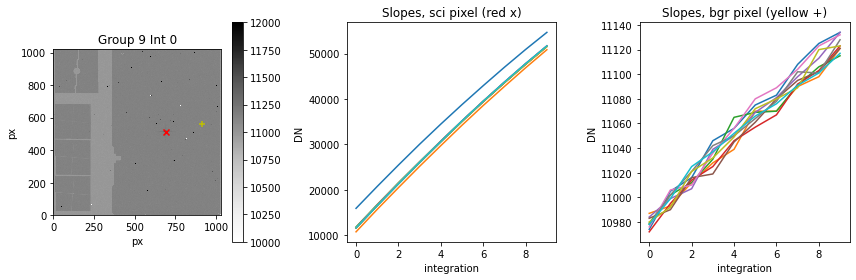

In [8]:
sci_data = model.data

ngroups = model.meta.exposure.ngroups
nints = model.meta.exposure.nints

# identify a science pixel
sci_px = [512, 692]

# identify a pixel in blank sky
bgr_px = [560, 915]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])

# plot 1: frame[-1] in the first integration
lastgrp = ax[0].imshow(sci_data[0,ngroups-1,:,:], origin='lower', interpolation='None', aspect='equal', cmap='Greys',
                      vmin=10000, vmax=12000)
ax[0].scatter(sci_px[1], sci_px[0], marker='x', color='r', label='sci pixel')
ax[0].scatter(bgr_px[1], bgr_px[0], marker='+', color='y', label='bgr pixel')
ax[0].set_title('Group {} Int 0'.format(ngroups-1))
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

# plot 2: pixel slope, spectrum

ax[1].set_title('Slopes, sci pixel (red x)')
for i in range(nints):
    ax[1].plot(sci_data[i, :, sci_px[0], sci_px[1]])
ax[1].set_xlabel('integration')
ax[1].set_ylabel('DN')

# plot 3: pixel slope, background

ax[2].set_title('Slopes, bgr pixel (yellow +)')
for i in range(nints):
    ax[2].plot(sci_data[i, :, bgr_px[0], bgr_px[1]])
ax[2].set_xlabel('integration')
ax[2].set_ylabel('DN')

fig.colorbar(lastgrp, ax=ax[0])
fig.tight_layout()

## Test individual output

### Test Saturation output

The saturation step should flag any saturated pixels in the DQ extension. We check this here by stepping through each integration and looking at the pixel values in a 25 x 25 px box, and checking the maximum counts against the groupdq attribute of the saturation output model. 

The code below should check that pixels with counts > satvalue are flagged, and report an error if the groupdq flag is incorrect.

In [9]:
# read in file output from saturation step

with RampModel(outname+'_saturation.fits') as satmodel:
    # raises exception if file is not the correct model
    data = satmodel.data
    satdq = satmodel.groupdq

satvalue = 55000
print('Saturation level is: ', satvalue, ' counts.')

# Test last frame of each integration for saturation and see if it was flagged.

ngroups = model.meta.exposure.ngroups
nints = model.meta.exposure.nints

for integration in range(nints):
    # check last frame for saturation in region of star
    box = data[integration, ngroups-1 , 500:525, 680:705]
    print()
    print('Max value in 25x25 box around star position: ',np.nanmax(box))
    satframe = satdq[integration, ngroups-1, 500:525, 680:705 ]
    
    satpix = (box >= satvalue)

    # if pixels greater than value, then check that they are flagged
    if satpix.any():
        print('Saturation detected in last frame of integration: ', integration)
        assert np.all(satframe[satpix] == dqflags.group['SATURATED'])
    else:
        print('No pixels saturate in last frame of integration: ', integration)

2021-04-22 16:44:55,262 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Saturation level is:  55000  counts.

Max value in 25x25 box around star position:  56628.0
Saturation detected in last frame of integration:  0

Max value in 25x25 box around star position:  52538.0
No pixels saturate in last frame of integration:  1

Max value in 25x25 box around star position:  53514.0
No pixels saturate in last frame of integration:  2

Max value in 25x25 box around star position:  53382.0
No pixels saturate in last frame of integration:  3

Max value in 25x25 box around star position:  53313.0
No pixels saturate in last frame of integration:  4

Max value in 25x25 box around star position:  53363.0
No pixels saturate in last frame of integration:  5

Max value in 25x25 box around star position:  53398.0
No pixels saturate in last frame of integration:  6

Max value in 25x25 box around star position:  53399.0
No pixels saturate in last frame of integration:  7

Max value in 25x25 box around star position:  53423.0
No pixels saturate in last frame of integration:  8

### Look at plots of output
Compare the slope image from the _rate output file to the median of the slopes of the _rateints file. They should be similar in appearance and flux levels.

2021-04-22 16:44:55,813 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Max DN/s in the rate.fits slope image: 1809.980712890625 DN/s


Max DN/s of the median of the rateints.fits slope images: 1810.7647705078125 DN/s


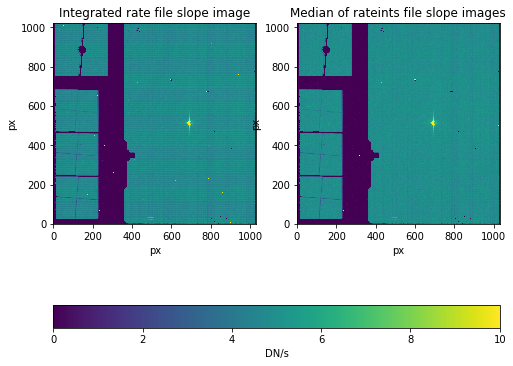

In [10]:
# this plot will compare the slope image from the _rate file with the median of the slope images in the rateints file
# check criterion: they should look similar and the maximim values seen in both these images should be similar

#with ImageModel(outname+'_rate.fits') as rmod:
    # raises exception if file is not the correct model
#    rdata = rmod.data
 
#with CubeModel(outname+'_rateints.fits') as rimod:
    # raises exception if file is not the correct model
#    rimoddata = rimod.data

rmod = ImageModel(outname+'_rate.fits')
rdata = rmod.data
rimod = CubeModel(outname+'_rateints.fits')
rimoddata = rimod.data

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,10])

rplt = ax[0].imshow(rdata, origin='lower', aspect='equal', interpolation='None', vmin=0, vmax=10)
ax[0].set_title('Integrated rate file slope image')
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

riplt = ax[1].imshow(np.median(rimoddata, axis=0), origin='lower', aspect='equal', interpolation='None',
                    vmin=0, vmax=10)
ax[1].set_title('Median of rateints file slope images')
ax[1].set_xlabel('px')
ax[1].set_ylabel('px')

cbar = fig.colorbar(rplt, ax=ax, orientation='horizontal')
cbar.set_label('DN/s')
#fig.tight_layout()

print('Max DN/s in the rate.fits slope image: {} DN/s'.format(np.max(rdata)))
print('Max DN/s of the median of the rateints.fits slope images: {} DN/s'.format(np.nanmax(np.median(rimoddata, axis=0))))

### Test output of jump step to see if specified pixels (and their neighbors) were flagged

In this step we check the output of the jump detection step. This looks at the pixels to which a CR hit was added above, and checks whether they were flagged. The threshold can be adjusted above, and the step re-run to check consistence with the input. 

In [11]:
# load jump step output file
with RampModel(outname+'_jump.fits') as jumpim:
    # raises exception if file is not the correct model
    jumpdata = jumpim.data
    jumpdq = jumpim.groupdq
    
integration = 0
frame = 5

# look for cr flags in dq grpdq array in specified locations
dqframe = jumpdq[integration, frame, :, :]

# print output on which fluxes had neighbors flagged
# output should include pixel coord, average pixel value nearby, cr value, whether neighbors were flagged
print('   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged \n')
for x, y, crmag in zip(xpos, ypos, crmags):
    # check if pixel is flagged
    # set default flag
    pixflagged = False
    neighborflagged = False

    # get stats on flux values near cr hit
    avgcounts = np.mean(jumpdata[integration, frame, y - 10: y - 5, x - 10: x - 5])

    if dqframe[y, x] & dqflags.pixel['JUMP_DET'] > 0:
        pixflagged = True
        # check neighbor pixels
        if ((dqframe[y + 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y - 1, x] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x + 1] & dqflags.pixel['JUMP_DET'] > 0) and
            (dqframe[y, x - 1] & dqflags.pixel['JUMP_DET'] > 0)):
                neighborflagged = True

    # write output
    print('{:8.0f} {:8.0f} {:10.0f} {:15.2f} {:>10} {:>10} \n'.format(x, y, crmag, avgcounts, str(pixflagged), 
                                                                      str(neighborflagged)))

2021-04-22 16:44:56,682 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



   xpos       ypos      crmag      avgcounts  pixflagged  neighborflagged 

     460      150         10        10084.64      False      False 

     480      150         25        10087.25      False      False 

     500      150         50        10087.82      False      False 

     520      150        100        10087.26       True      False 

     540      150        200        10087.80       True       True 

     560      150        500        10085.96       True       True 

     580      150       1000        10086.31       True       True 



2021-04-22 16:44:57,236 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



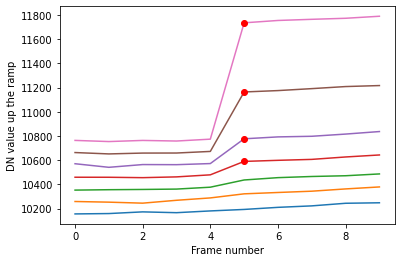

In [12]:
# plot data to see what is being flagged
i=10
nframes = model.meta.exposure.ngroups
frames = np.arange(nframes)

# set up titles for plot
plt.xlabel('Frame number')
plt.ylabel('DN value up the ramp')

for x, y in zip(xpos, ypos):
    # get locations of flagged pixels within the ramps
    jumps = jumpdq[integration, :, y, x] & dqflags.pixel['JUMP_DET'] > 0
    ramp = jumpdata[integration, :, y, x]

    # plot ramps of selected pixels and flagged jumps
    plt.plot(ramp+i*10)
    plt.plot(frames[jumps], ramp[jumps]+i*10, color='r', marker='o')
    i = i+10

#plt.legend()
plt.show()

2021-04-22 16:44:57,334 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



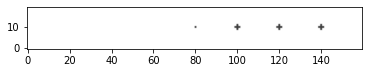

In [13]:
# show region of dq array to see if cross pixels were flagged 
data = jumpdq[integration, frame, 140:160, 440:600]
plt.imshow(data, cmap='Greys', origin='lower', vmin=0,vmax=5)
plt.show()

### RSCD testing
The RSCD step at the moment simply flags frames as 'DO_NOT_USE' in the groupdq array to avoid the frames that show the rscd effect being used for ramp fitting.

For FULL frame FAST mode data, the RSCD reference file indicates that the first four frames in all integrations greater than 1 (or 0 for 0-indexing), should be flagged as 'DO_NOT_USE', which is indicated by a value 1 in the groupdq array. If the value of the flag in the frame is odd, then this frame has been correctly flagged.

In [14]:
# Use the groupdq output of the jump step to test whether the proper frames are flagged.
# Choose any pixel in the frame (500, 500) to test, since they should all be flagged the same.

print(jumpdq[:,:,500,500])

[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]]


<a id="about_ID"></a>
## About this Notebook
**Author:** Misty Cracraft, Senior Staff Scientist, MIRI Branch
<br>**Updated On:** 07/28/2020